In [1]:
import numpy as np
from seisLM.data_pipeline.foreshock_aftershock_dataset import (
  create_foreshock_aftershock_datasets
)
from seisLM.data_pipeline.foreshock_aftershock_dataloaders import (
  prepare_foreshock_aftershock_dataloaders)
import pandas as pd
import matplotlib.pyplot as plt
from seisLM.utils.project_path import gitdir
NUM_CLASSES = 4

/home/liu0003/miniconda3/envs/seisbench/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import json
import ml_collections
import torch
from seisLM.model.task_specific.foreshock_aftershock_models import (
  Conv1DShockClassifierLit, Wav2vec2ShockClassifierLit)


def get_conv1d_config():
  config_path = gitdir() + '/seisLM/configs/foreshock_aftershock/conv1d_shock_classifier.json'
  with open(config_path, "r", encoding="utf-8") as f:
    config = json.load(f)
  config = ml_collections.ConfigDict(config)
  config.model_args.num_classes = NUM_CLASSES
  return config

config = get_conv1d_config()
data_args = config.data_args

# model = Conv1DShockClassifierLit(
#   model_config=config.model_args,
#   training_config=config.trainer_args,
#   ).model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Conv1DShockClassifierLit.load_from_checkpoint(
  gitdir() + "/results/models/foreshock_aftershock_run/num_classes_4_seed_42_model_Conv1DShockClassifier_time_2024-08-07-14h-54m-40s/checkpoints/epoch=37-step=6042.ckpt"
).model

model = model.to(device)


In [3]:
loaders = prepare_foreshock_aftershock_dataloaders(
  num_classes=model.config.num_classes,
  **data_args
)

Seed set to 42
Seed set to 42


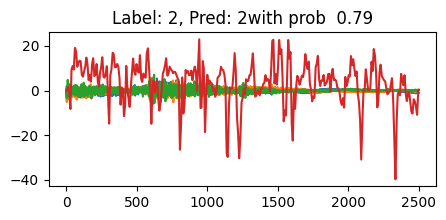

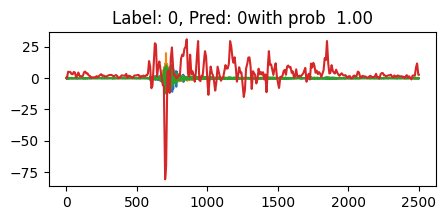

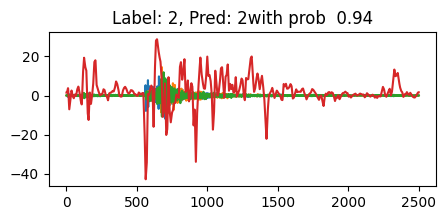

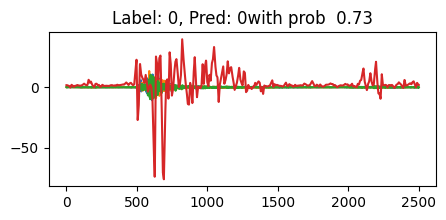

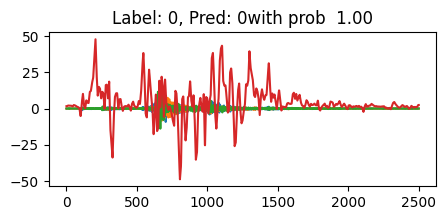

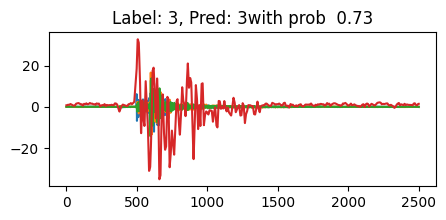

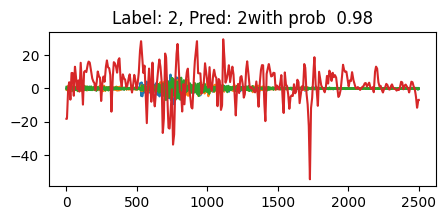

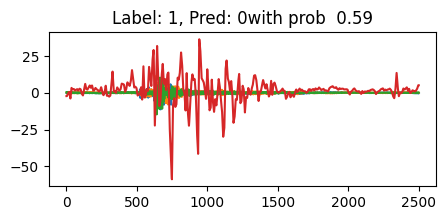

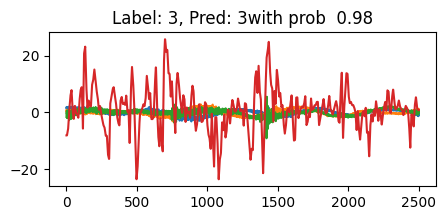

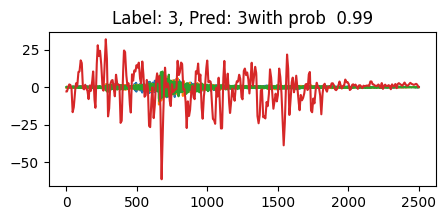

In [4]:
waveforms, labels = next(iter(loaders['train']))

with torch.no_grad():
  cam_output = model.get_cam(waveforms.to(device)).cpu()
  pred_prob = torch.nn.functional.softmax(model(waveforms.to(device)), dim=1)
  label = pred_prob.argmax(dim=1)

# idx = 0
for idx in range(10):
  plt.figure(figsize=(5, 2))
  plt.plot(waveforms[idx].numpy().T)
  plt.plot(cam_output[idx].numpy().T)
  plt.title(f'Label: {labels[idx].item()}, Pred: {label[idx].item()}' \
    f'with prob {pred_prob[idx].max().item(): .2f}')


<Figure size 800x800 with 0 Axes>

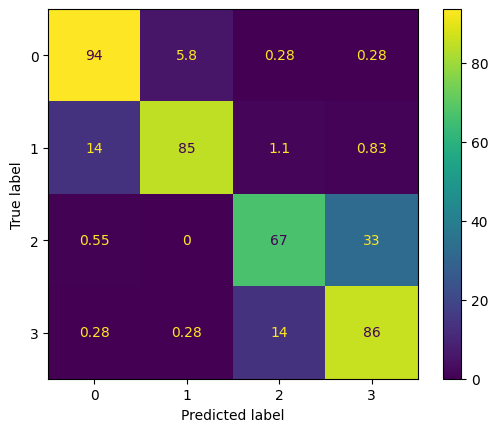

In [5]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


all_gt_class = []
all_pred_class = []

# pooled_feats = []
for X, y in loaders['test']:

  with torch.no_grad():
    logits, feat = model(X.to(device), return_features=True)
    logits = logits.cpu().numpy()
    pooled_feat = model.global_pool(feat).cpu().numpy()
    pred_class = np.argmax(logits, axis=1)

  all_gt_class.append(y)
  all_pred_class.append(pred_class)

all_gt_class = np.concatenate(all_gt_class)
all_pred_class = np.concatenate(all_pred_class)


cm = confusion_matrix(all_gt_class, all_pred_class)

cm_percentage = 100 * cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_percentage)
disp.plot()

## examine the importance of std norm

In [8]:
import seisLM.data_pipeline.foreshock_aftershock_dataset as dataset

datasets = dataset.create_foreshock_aftershock_datasets(
  num_classes=4,
  event_split_method=data_args.event_split_method,
  component_order=data_args.component_order,
  dimension_order=data_args.dimension_order,
  seed=42,
  remove_class_overlapping_dates=False,
  train_frac=data_args.train_frac,
  val_frac=data_args.val_frac,
  test_frac=data_args.test_frac,
)



Seed set to 42
Seed set to 42


In [13]:

def normalize(X: np.ndarray, demean_axis=-1, amp_norm_axis=-1, amp_norm_type='std') -> np.ndarray:

  if demean_axis is not None:
    X = X - np.mean(X, axis=demean_axis, keepdims=True)

  if amp_norm_axis is not None:
    if amp_norm_type == 'std':
      X = X / (np.std(X, axis=amp_norm_axis, keepdims=True) + 1e-10)
    elif amp_norm_type == 'peak':
      X = X / (np.max(np.abs(X), axis=amp_norm_axis, keepdims=True) + 1e-10)
    else:
      raise ValueError(f'Normalization type {amp_norm_type} not supported')
  return X


In [16]:
std_normed = normalize(datasets['train']['X'], amp_norm_type='std')
peak_normed = normalize(datasets['train']['X'], amp_norm_type='peak')

<Figure size 500x200 with 0 Axes>

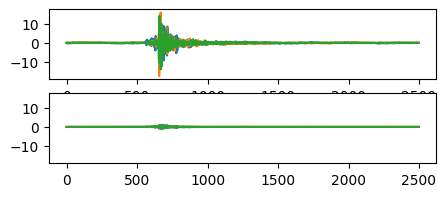

In [20]:
idx = 0

plt.figure(figsize=(5, 2))

_, axes = plt.subplots(2, 1, figsize=(5, 2))

axes[0].plot(std_normed[idx].T)
axes[1].plot(peak_normed[idx].T)

axes[0].sharey(axes[1])
# plt.title('Standard normalized')
